## Plotting the epicenters of earthquakes on a map

This notebook shows how to use [GeoPandas](https://geopandas.org/en/stable/) to plot the epicenters of earthquakes on a map. It owes a few details to a [tutorial](https://jcutrer.com/python/learn-geopandas-plotting-usmaps) by Jonathan Cutrer, a software developer from Austin, Texas who blogs about all sorts of technological things. 

## Preliminaries

Before starting to use this notebook, install GeoPandas by following these [instructions](https://geopandas.org/en/stable/getting_started.html). I'll provide all the map data that you need, but if you want to work with maps for some other region, you'll need to get suitable [*shapefiles*](https://en.wikipedia.org/wiki/Shapefile). These are available from lots of places, including:

   * [GeoFabrik](http://download.geofabrik.de)
   * [IGISMap](https://www.igismap.com/download-world-shapefile-free-country-borders-continents/)
   * sites listed at [Stat Silk](https://www.statsilk.com/maps/download-free-shapefile-maps)
   * other sites listed on the [Open Street Map Wiki](https://wiki.openstreetmap.org/wiki/Shapefiles)

Here we'll use `*.shp` files provided by the USA's [Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html).

In [1]:
# Import all the usual things
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Then get GeoPandas and related tools
import geopandas as gpd
from shapely.geometry import Point

Before doing anything else, ensure there's a Figures directory to receive the maps we'll plot.

In [2]:
# https://www.tutorialspoint.com/How-can-I-create-a-directory-if-it-does-not-exist-using-Python
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')

#### Read the earthquake data

In [3]:
# Read in the data as a Pandas dataframe
quake_df = pd.read_csv('Data/earthquakes_US_14Jul-13Aug_2018.csv')
quake_df.head() # shows the first few rows of the dataframe

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2018-08-13T20:32:00.830Z,33.860333,-117.501167,1.50,1.56,ml,29.0,44.0,0.06337,0.2600,...,2018-08-13T20:35:51.429Z,"3km SE of Home Gardens, CA",quarry blast,0.38,0.71,0.213,37.0,automatic,ci,ci
1,2018-08-13T20:15:08.350Z,33.523667,-116.747333,3.69,0.40,ml,14.0,90.0,0.04246,0.0800,...,2018-08-13T20:18:36.325Z,"8km WSW of Anza, CA",earthquake,0.18,0.42,0.137,9.0,automatic,ci,ci
2,2018-08-13T20:11:13.973Z,40.601000,-115.955500,0.00,2.20,ml,12.0,108.3,0.43800,0.1944,...,2018-08-13T20:28:20.650Z,"17km SE of Carlin, Nevada",explosion,NaN,0.00,0.080,8.0,reviewed,nn,nn
3,2018-08-13T20:09:39.080Z,33.482333,-116.744333,7.91,0.34,ml,18.0,65.0,0.06527,0.1800,...,2018-08-13T20:13:23.288Z,"10km SW of Anza, CA",earthquake,0.35,0.86,0.093,8.0,automatic,ci,ci
4,2018-08-13T19:59:26.490Z,33.491167,-116.795500,2.54,0.39,ml,11.0,109.0,0.08857,0.0800,...,2018-08-13T20:02:57.234Z,"8km NE of Aguanga, CA",earthquake,0.26,0.37,0.055,8.0,automatic,ci,ci


#### Read the shapefile describing the map

In [4]:
shapefilePath = "Data/USA_States_Census2021.shp"
usa_gpdf = gpd.read_file( shapefilePath )
usa_gpdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,22,01629543,0400000US22,22,LA,Louisiana,00,111915258185,23736382213,"POLYGON ((-94.04305 32.69303, -94.04303 32.797..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1478942847588,245378425142,"MULTIPOLYGON (((179.48132 51.97530, 179.58286 ..."
2,24,01714934,0400000US24,24,MD,Maryland,00,25151992308,6979074857,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
3,55,01779806,0400000US55,55,WI,Wisconsin,00,140292321657,29343646672,"MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ..."
4,12,00294478,0400000US12,12,FL,Florida,00,138961722096,45972570361,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."


## Making the map

As this is mainly a demonstration, rather than a thorough exploration of the data, we'll plot subsets of the data that lead to nice-looking figures.

#### Restrict attention to the contiguous states and plot them

Make a new data frame that includes only the 48 contiguous states and the District of Columbia (which contains the nation's capitol, Washington).

In [5]:
# Get a list of the names of the regions we want to keep
allNames = set( usa_gpdf['NAME'] )
toDrop = set( ["Alaska", "Hawaii", "Puerto Rico"] )
lower48 = allNames - toDrop
print( lower48 )

{'Connecticut', 'West Virginia', 'Montana', 'Maryland', 'Oregon', 'Ohio', 'New Hampshire', 'Florida', 'Minnesota', 'Oklahoma', 'Rhode Island', 'California', 'Arkansas', 'Arizona', 'Texas', 'New Mexico', 'Georgia', 'Pennsylvania', 'Massachusetts', 'Alabama', 'District of Columbia', 'North Dakota', 'Kansas', 'Utah', 'Iowa', 'Kentucky', 'Mississippi', 'Indiana', 'Illinois', 'Colorado', 'Nevada', 'Maine', 'Louisiana', 'Wyoming', 'South Dakota', 'Wisconsin', 'Missouri', 'New York', 'Washington', 'Idaho', 'Virginia', 'Michigan', 'North Carolina', 'Vermont', 'Tennessee', 'South Carolina', 'New Jersey', 'Delaware', 'Nebraska'}


In [6]:
# Make a new data frame with only the keepers
lower48_gpdf = usa_gpdf[usa_gpdf['NAME'].isin(lower48)]

<AxesSubplot:>

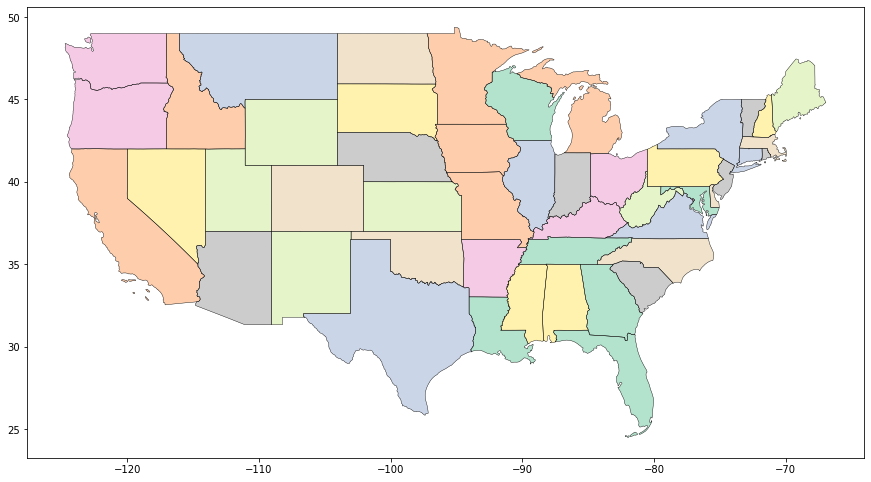

In [7]:
# Plot those puppies
width = 15
height = 10 
usaFig, usaAxes = plt.subplots( figsize=(width, height) )
baseMapAxes = lower48_gpdf.boundary.plot( ax=usaAxes, color='Black', linewidth=.4)
lower48_gpdf.plot( ax=baseMapAxes, cmap='Pastel2' )

### Plot points at the positions of the epicenters

First we build a new GeoPandas dataframe from the original earthquake (Pandas) dataframe. This is discussed in the [GeoPandas documentation].

In [8]:
# Get a set of Point objects for the epicenters of the quakes
quake_pts = gpd.points_from_xy( quake_df['longitude'], quake_df['latitude'] )

# Use them to assemble a GeoPandas dataframe
quake_gpdf = gpd.GeoDataFrame( quake_df[['time', 'depth', 'mag', 'place']], geometry=quake_pts )
quake_gpdf.head()

,time,depth,mag,place,geometry
0,2018-08-13T20:32:00.830Z,1.50,1.56,"3km SE of Home Gardens, CA",POINT (-117.50117 33.86033)
1,2018-08-13T20:15:08.350Z,3.69,0.40,"8km WSW of Anza, CA",POINT (-116.74733 33.52367)
2,2018-08-13T20:11:13.973Z,0.00,2.20,"17km SE of Carlin, Nevada",POINT (-115.95550 40.60100)
3,2018-08-13T20:09:39.080Z,7.91,0.34,"10km SW of Anza, CA",POINT (-116.74433 33.48233)
4,2018-08-13T19:59:26.490Z,2.54,0.39,"8km NE of Aguanga, CA",POINT (-116.79550 33.49117)


#### Sort out the coordinate systems

Next we transform the positions of the epicenters into the coordinate system used by `lower48_gpdf`. This is probably the most subtle and confusing aspect of the project. The issue is that there are *lots* of coordinate systems currently in use for the earth and the one used by the US Geological Survey (USGS) to report the epicenters of earthquakes differs from the one used in the Census Bureau's boundary maps. 

In the code below, we first note that the USGS data use the [WGS84](http://wiki.gis.com/wiki/index.php/WGS84) coordinate reference system (CRS): I learned this from the [documentation](https://earthquake.usgs.gov/data/comcat/#latitude) for their online catalog of earthquakes. We then transform the epicenter coordinates into the CRS used for the Census Bureau's maps.

In [9]:
# First note the CRS originally used for the earthquake data
# See the Additional Information section at https://earthquake.usgs.gov/data/comcat/#latitude
quake_gpdf.set_crs( crs='WGS84', inplace=True ) # inplace=True means we'll alter quake_gpdf itself, rather than a copy

# Now transform to the coordinate system used in the Census Bureau's map
quake_gpdf.to_crs( lower48_gpdf.crs, inplace=True )

#### Plot the locations of the quakes

<AxesSubplot:>

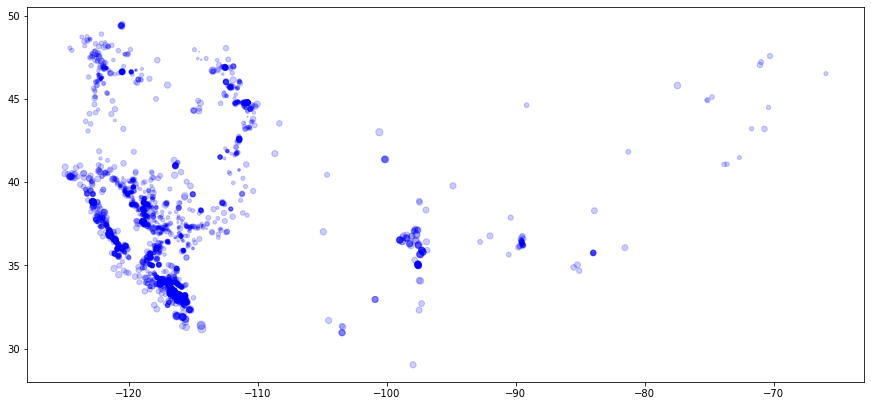

In [10]:
# Set the marker sizes: this needed a bit of trial and error
magnitudeToMarkersize = 15.0 # Adjust this to get nice-looking plots
pt_sizes = magnitudeToMarkersize * quake_gpdf['mag'].to_numpy() 

# Plot the epicenters as semi-transparent disks
tmpFig, tmpAxes = plt.subplots(figsize=(width, height))
tmpAxes.set_aspect( baseMapAxes.get_aspect() ) # Use the same aspect ratio as the plot above
quake_gpdf.plot( ax=tmpAxes, color='blue', markersize=pt_sizes, alpha=0.2 )

#### Put everything together

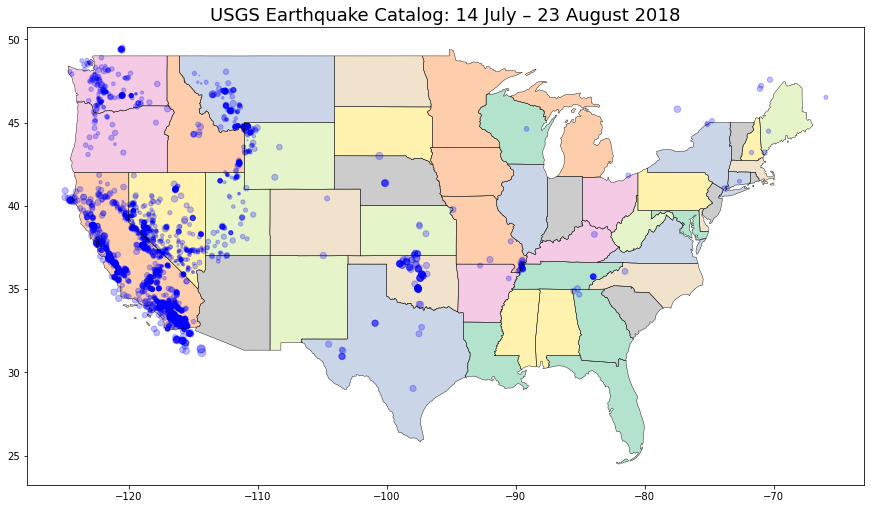

In [11]:
# Set up the axes
# See https://geopandas.org/en/stable/docs/user_guide/mapping.html#maps-with-layers
# for a discussion of the need for set_aspect()
finalFig, finalAxes = plt.subplots( figsize=(width, height) )
finalAxes.set_aspect( baseMapAxes.get_aspect() )

# Plot everything together
baseMap = lower48_gpdf.boundary.plot( ax=finalAxes, color='Black', linewidth=.4 )
lower48_gpdf.plot( ax=finalAxes, cmap='Pastel2' )
quake_gpdf.plot( ax=finalAxes, markersize=pt_sizes, color='blue', alpha=0.25 )
finalAxes.set_title( "USGS Earthquake Catalog: 14 July – 23 August 2018", fontsize=18 )

# Save a copy
finalFig.savefig( "Figures/EarthquakeMap.pdf" )